## SIMULATOR AND SUMMARY STATISTICS

In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.append("./../..")

In [2]:
# Load the minimum required library to run the functions
#from Utils_functions import *
from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle

import sympy as sym


2024-06-08 17:59:35.660540: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-08 17:59:35.923724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 17:59:35.923787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 17:59:35.968616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 17:59:36.063436: I tensorflow/core/platform/cpu_feature_guar

In [3]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 13 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
transient = 3
t_corr = TotalT/50

# n_sim = int(10)


In [4]:
time_steps_amount = np.int64((TotalT-transient)/dt) # Number of steps
sampled_point_amount = np.int64((TotalT-transient)/DeltaT) # Number of sampled points
sampling_delta_time_steps = np.int64(DeltaT/dt) # Number of steps between samples
t = np.linspace(0., TotalT - transient, sampled_point_amount) # Time array

In [5]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [6]:
tnice = [DeltaT for t in range(sampled_point_amount - 1)]

In [7]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

### If you want to compute simulations

In [9]:
n_sim = int(20)

In [10]:
%%time
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

CPU times: user 1min 6s, sys: 141 ms, total: 1min 6s
Wall time: 1min 6s


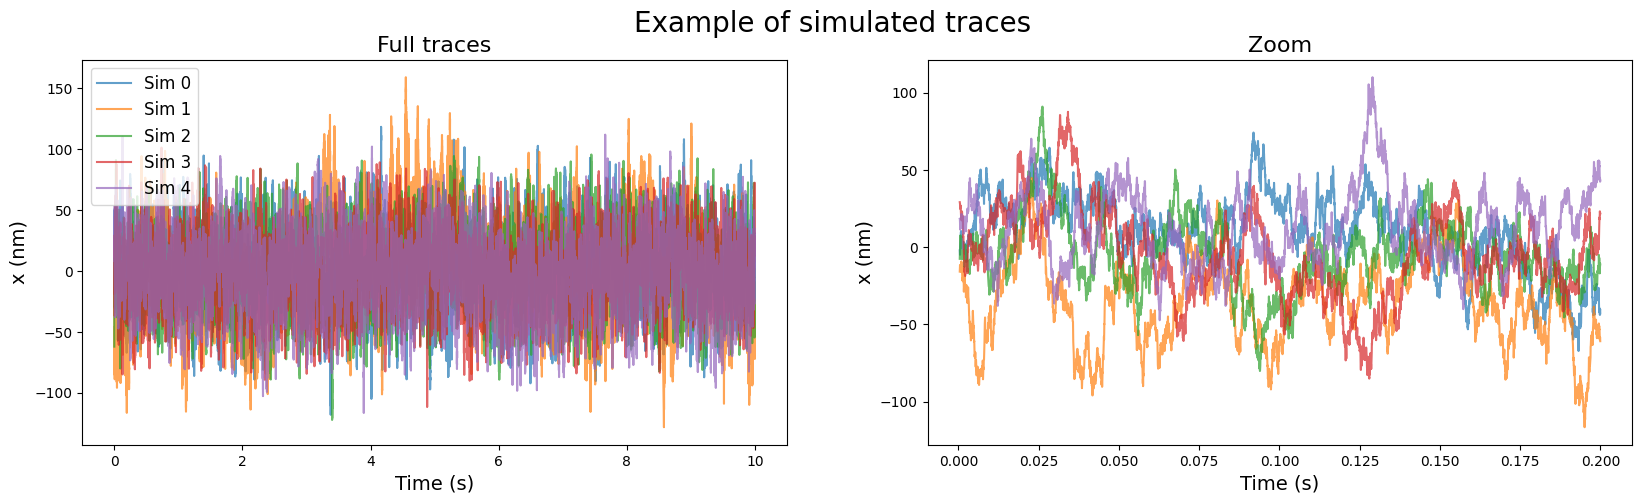

In [ ]:
# Example of simulated traces
plt.figure(figsize=(20, 5))
plt.suptitle("Example of simulated traces", fontsize=20)

plt.subplot(121)
for i in range(min([n_sim, 5])):
    plt.plot(t, x_trace[i], label=f"Sim {i}", alpha=0.7)
plt.title("Full traces", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
for i in range(min([n_sim, 5])):
    plt.plot(t[10:5000], x_trace[i, 10:5000], label=f"Sim {i}", alpha=0.7)
plt.title("Zoom", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14);


In [11]:
%%time
# Compute the summary statistics from the simulations 
selected_stats = ["s_redx"]
z_score = False

first = True
for i in range(n_sim):
    print("i = ", i+1, end="\r")  
    summary_stats = compute_summary_statistics(x_trace[i], theta[:,i])
    s_i = select_summary_statistics(summary_stats, selected_stats, DeltaT, z_score=z_score)
    
    if first:
        s_tot = s_i
        theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
        summary_stats_length = [len(summary_stats[s]) for s in selected_stats]
        print("Length of each summary statistics: ", summary_stats_length)
        first = False
    else:
        s_tot = torch.cat((s_tot, s_i), dim=0)
        theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)

print("s_tot shape: ", s_tot.shape, ",  theta_tot shape: ", theta_tot.shape)

Length of each summary statistics:  [17499]
s_tot shape:  torch.Size([5, 17499]) ,  theta_tot shape:  torch.Size([5, 5])
CPU times: user 1min 49s, sys: 193 ms, total: 1min 49s
Wall time: 1min 50s


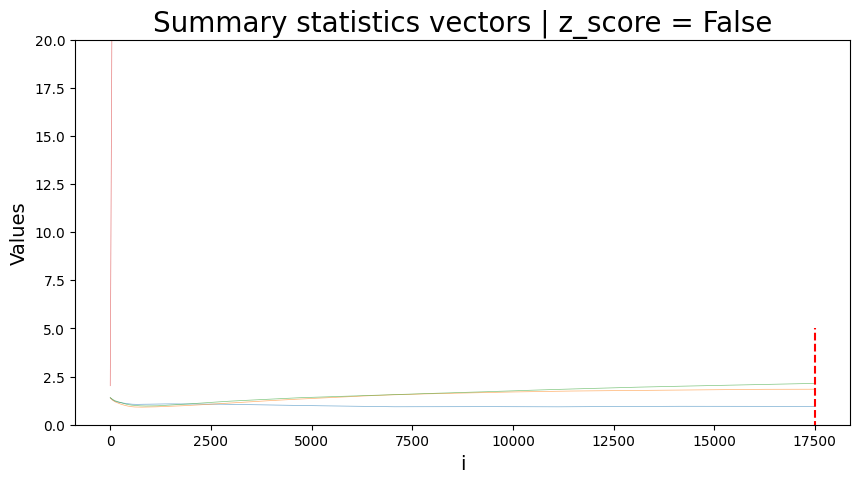

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Summary statistics vectors | z_score = " + str(z_score), fontsize=20)
plt.xlabel("i", fontsize=14)
plt.ylabel("Values", fontsize=14)
#plt.plot(s_tot[0, :])
#plt.xscale("log")
plt.ylim(0, 20)

for i in range(1, min([s_tot.shape[0], 20])):
    plt.plot(s_tot[i, :], lw=0.5, alpha=0.6)

plt.vlines(x=np.cumsum(summary_stats_length), ymin=-4, ymax=5, color='r', linestyles='dashed');

### If you want to load from file

In [8]:
def stat_fit_corr(single_corr, DeltaT):
    """
    Fit the correlation function with a sum of 3 exponentials
    """
    t_cxx = np.linspace(0., (len(single_corr)+1)*DeltaT, (len(single_corr)+1))[1:]
    
    def cxx_exp3(t, a1, a2, a3, b1, b2, b3):
        return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)
    
    try: 
        popt, pcov = curve_fit(cxx_exp3, t_cxx, single_corr, p0=[1e2, 1e2, 1e2, 10, 10, 10], maxfev=5000)
    except:
        return np.zeros(6)

    return popt, cxx_exp3(t_cxx, *popt)

In [9]:
def stat_fit_s_redx(single_s_redx, DeltaT, mode="exp"):
    """
    Fit the s_redx function
    """
    assert mode in ["exp", "simple"], "Mode not recognized"

    t_cxx = np.linspace(0., (len(single_s_redx)+1)*DeltaT, (len(single_s_redx)+1))[1:]
    
    def s_redx_simple(t, a, tau):
        return(1 + a*t/(1+t/tau))

    def s_redx_exp(t, a1, a2, b1, b2, b3, c):
        a3 = 1 - a1 - a2 
        sum_exp = a1*np.exp(-b1*t) + (a2)*np.exp(-(b1+b2)*t) + (a3)*np.exp(-(b1+b2+b3)*t)
        sum = a1*b1 + (a2)*(b1+b2) + (a3)*(b1+b2+b3)
        tau = 1/sum
        return(1 + c - (c*tau/t)*(1-sum_exp))
    
    if mode == "exp":
        try: 
            popt, pcov = curve_fit(s_redx_exp, t_cxx, single_s_redx, p0=[1, 10, 10, 0.1, 0.01, 10],
                          bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]), maxfev=5000)
        except:
            return np.zeros(6)
        return popt, s_redx_exp(t_cxx, *popt)

    if mode == "simple":
        try:
            popt, pcov = curve_fit(s_redx_simple, t_cxx, single_s_redx, p0=[1e3, 1e-2],
                          bounds=([0, 0], [np.inf, np.inf]), maxfev=5000)
        except:
            return np.zeros(6)
        return popt, s_redx_simple(t_cxx, *popt)

In [8]:
def select_summary_statistics(summary_statistics, selected_statistics, DeltaT,
                              z_score=False, cl_lin=-1, cl_log=-1, fit_cxx=False, fit_s_redx=False):
    selected_statistics = selected_statistics.copy()
    
    # Check that the selected statistics are in the summary statistics
    assert set(selected_statistics).issubset(set(summary_statistics.keys()))
    "The selected statistics are not in the summary statistics"

    # Checks on postprocessing
    assert cl_log < 0 or cl_lin < 0, "You cannot subsample bot 'lin' and 'log' at the same time"
    if cl_lin > 0 or cl_log > 0: assert (fit_cxx == False) and (fit_s_redx == False), "You cannot subsample and fit at the same time"
    
    # Post-subselection of Cxx and s_redx
    if cl_lin > 0:
        idx_clean_corr = np.linspace(0, len(summary_statistics["Cxx"])-1, cl_lin, dtype=np.int32)
        if "Cxx" in selected_statistics:
            summary_statistics["Cxx"] = summary_statistics["Cxx"][idx_clean_corr]
        if "s_redx" in selected_statistics:
            summary_statistics["s_redx"] = summary_statistics["s_redx"][idx_clean_corr]
        if "s_red1" in selected_statistics:
            summary_statistics["s_red1"] = summary_statistics["s_red1"][idx_clean_corr]
        if "s_red2" in selected_statistics:
            summary_statistics["s_red2"] = summary_statistics["s_red2"][idx_clean_corr]

    if cl_log > 0:
        idx_clean_corr = np.logspace(0, np.log10(len(summary_statistics["Cxx"])-1), cl_log, dtype=np.int32)
        if "Cxx" in selected_statistics:
            summary_statistics["Cxx"] = summary_statistics["Cxx"][idx_clean_corr]
        if "s_redx" in selected_statistics:
            summary_statistics["s_redx"] = summary_statistics["s_redx"][idx_clean_corr]
        if "s_red1" in selected_statistics:
            summary_statistics["s_red1"] = summary_statistics["s_red1"][idx_clean_corr]
        if "s_red2" in selected_statistics:
            summary_statistics["s_red2"] = summary_statistics["s_red2"][idx_clean_corr]

    # Fit Cxx and s_redx ex post and use the paramaters as summary statistics
    if fit_cxx and "Cxx" in selected_statistics:
        summary_statistics["Cxx"] = stat_fit_corr(summary_statistics["Cxx"], DeltaT)[0]
        if (summary_statistics["Cxx"] == np.zeros(6)).all(): return None

    if fit_s_redx and "s_redx" in selected_statistics:
        summary_statistics["s_redx"] = stat_fit_s_redx(summary_statistics["s_redx"], DeltaT, mode=fit_s_redx)[0]
        if (summary_statistics["s_redx"] == np.zeros(6)).all(): return None

    # Check if the fit of Cxx or s_redx failed
    if ("s_redx_fit" in selected_statistics) and (summary_statistics["s_redx_fit"].all() == 0):
        return None
    if ("Cxx_fit" in selected_statistics) and (summary_statistics["Cxx_fit"].all() == 0):
        return None

    # Check if theta is selected for testing reasons
    theta_selected = False
    if "theta" in selected_statistics:
        theta_selected = True
        selected_statistics.remove("theta")

    # Get the selected summary statistics in a torch tensor
    if z_score:
        list_of_statistics = [torch.tensor(zscore(summary_statistics[i])) for i in selected_statistics]
    else:   
        list_of_statistics = [torch.tensor(summary_statistics[i]) for i in selected_statistics]
    selected_summary_statistics = torch.cat(list_of_statistics, dim=0)
    selected_summary_statistics = torch.unsqueeze(selected_summary_statistics, 0)

    # Add theta to the summary statistics if selected
    if theta_selected:
        theta = torch.tensor(summary_statistics["theta"])
        selected_summary_statistics = torch.cat((selected_summary_statistics, theta.T), dim=1)

    # Convert the summary statistics to float32 (required for sbi)
    selected_summary_statistics = selected_summary_statistics.to(torch.float32)
    return selected_summary_statistics

In [147]:
%%time
# Hyperparameters
selected_stats = ["s_redx_fit", "tucci", "Cxx"] # selected summary statistics
z_score = False # z-score normalization of the summary statistics
cl_log = 5 # post-subsampling of Cxx and s_redx (-1 for no post-subsampling)
cl_lin = -1
fit_corr = False
fit_s_redx = False # Implemented: "exp" or "simple"
skiped_simulations = 0

# List file in the directory SummaryStatistics
#files = os.listdir("../../Data/SummaryStatistics/20240515/")[:-1]
files = [os.path.join(root, file)
        for root, _, files in os.walk("../../Data/SummaryStatistics/")
        for file in files][1:-1]
print("Reading ", len(files), " file for a total of ", 200*len(files), " simulations... \n")
loaded_simul = 0

# Pipeline from the n_sim simulations to the be ready for training
first = True
for file in files:
    print("Reading file", file, " i =", loaded_simul, " / ", 200*len(files), end='\r')
    with open(f"{file}", "rb") as f:
        summary_stats_batch = pickle.load(f)
    
    for i in range(len(summary_stats_batch)):
        # Here handle the local simulations
        summary_stats = summary_stats_batch[i]
        s_i = select_summary_statistics(summary_stats, selected_stats, DeltaT,
                z_score=z_score, cl_lin=cl_lin, cl_log=cl_log, fit_cxx=fit_corr, fit_s_redx=fit_s_redx)
        
        if s_i == None: 
            skiped_simulations += 1
            print("Skiped simulations: ", skiped_simulations, end='\r')
            continue
        
        if first:
            s_tot = s_i
            theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
            summary_stats_length = [len(summary_stats[s]) for s in selected_stats]
            print("Length of each summary statistics: ", summary_stats_length)
            first = False
        else:
            s_tot = torch.cat((s_tot, s_i), dim=0)
            theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)
        
        loaded_simul += 1

theta_tot = theta_tot.T

print("Loaded simulations", loaded_simul)
print("s_tot.shape", s_tot.shape)
print("theta_tot.shape", theta_tot.shape)

Reading  51  file for a total of  10200  simulations... 

Length of each summary statistics:  [6, 21, 5]0521/20240521-124624_200sims_process2130304.pkl  i = 0  /  10200
Loaded simulations 10174SummaryStatistics/20240521/20240521-122641_200sims_process2130327.pkl  i = 9974  /  10200
s_tot.shape torch.Size([10174, 32])
theta_tot.shape torch.Size([10174, 5])
CPU times: user 11.8 s, sys: 1.7 s, total: 13.5 s
Wall time: 8.04 s


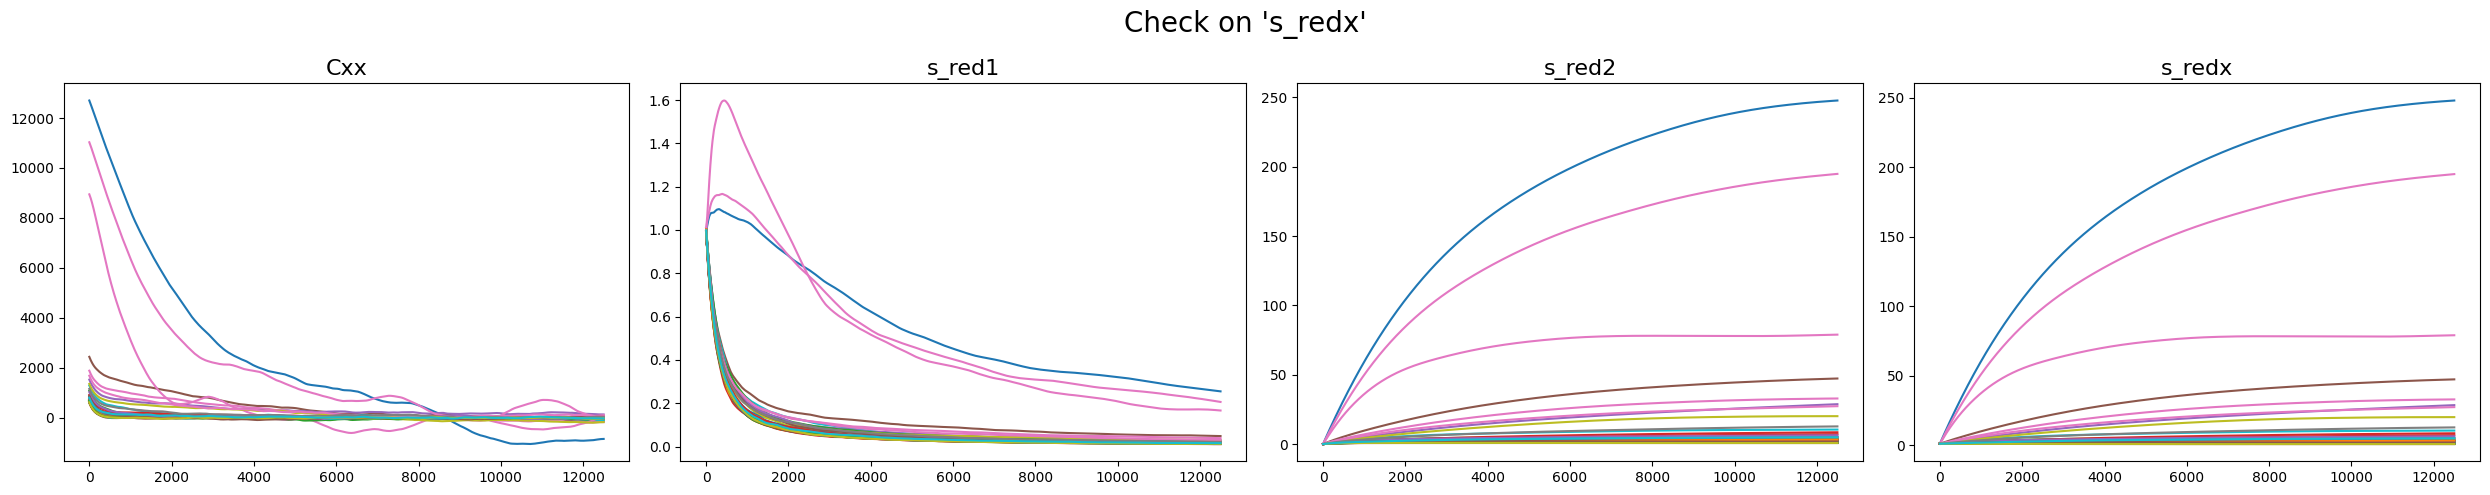

In [80]:
plt.figure(figsize=(25, 5))

if cl_log > 0: print("BE CAREFUL: YOU ARE SUBSAMPLING IN LOG SCALE")

plt.suptitle("Check on 's_redx'", fontsize=20)
plt.subplot(141)
for i in range(50): plt.plot(summary_stats_batch[i]["Cxx"])
plt.title("Cxx", fontsize=16)

plt.subplot(142)
for i in range(50): plt.plot(summary_stats_batch[i]["s_red1"])
plt.title("s_red1", fontsize=16)

plt.subplot(143)
for i in range(50): plt.plot(summary_stats_batch[i]["s_red2"])
plt.title("s_red2", fontsize=16)

plt.subplot(144)
for i in range(50): plt.plot(summary_stats_batch[i]["s_redx"])
plt.title("s_redx", fontsize=16)

plt.tight_layout();

### Visualization and normalization of $\theta$

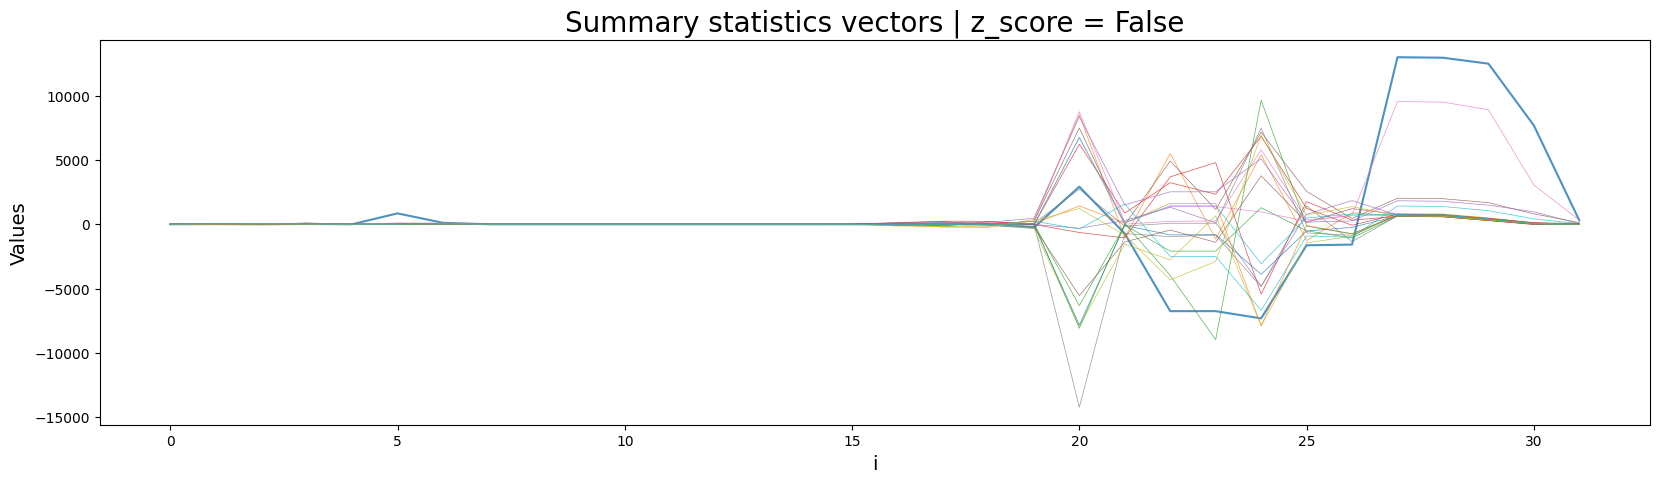

In [98]:
plt.figure(figsize=(20, 5))
plt.title("Summary statistics vectors | z_score = " + str(z_score), fontsize=20)
plt.xlabel("i", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.plot(s_tot[0, :], alpha=0.8)

for i in range(1, min([s_tot.shape[0], 20])):
    plt.plot(s_tot[i, :], lw=0.5, alpha=0.8)

plt.vlines(x=np.cumsum(summary_stats_length)-1, ymin=-4, ymax=5, color='r', linestyles='dashed');

In [148]:
# Rescale the parameters in [-0.5, 0.5]
theta_tot_norm = rescale_theta(theta_tot, prior_limits)

## INFERENCE

Additional things to try:
* Combinatorial game out of the summary statistics
* Other SNPE methods (https://sbi-dev.github.io/sbi/tutorial/16_implemented_methods/)
* Multi-round training (defining a priori the observation)?

In [149]:
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, SNPE_A, SNPE_C, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [150]:
# Prior distribution for sbi
prior_box = get_prior_box(prior_limits)

## Prior box if theta normalized:
prior_box = utils.torchutils.BoxUniform(low=torch.tensor([-0.5]*len(prior_limits)), high=torch.tensor([0.5]*len(prior_limits)))

prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [152]:
%%time
# Train the model (multiple time eventually, keep the best)
n_trials = 5
best = 0
for i in range(n_trials):
    # Call infer form sbi
    infer = SNPE(prior=prior)
    #inferece = infer.append_simulations(theta_tot, s_tot)
    inferece = infer.append_simulations(theta_tot_norm, s_tot)

    # Train the model
    density_estimator = infer.train(num_atoms=20, show_train_summary=False, 
                                    training_batch_size=50, learning_rate=0.005)
    print("\n Training ", i+1, " / 5: best validation performance: ", 
          round(infer.summary["best_validation_log_prob"][0], 3))

    if infer.summary["best_validation_log_prob"][0] > best:
        best = infer.summary["best_validation_log_prob"][0]
        best_density_estimator = density_estimator
        best_infer = infer
print("Best validation performance: ", best)  

# Build the posterior
posterior = best_infer.build_posterior(best_density_estimator)

 Neural network successfully converged after 140 epochs.
 Training  1  / 5: best validation performance:  6.063
 Neural network successfully converged after 123 epochs.
 Training  2  / 5: best validation performance:  6.525
 Neural network successfully converged after 88 epochs.
 Training  3  / 5: best validation performance:  5.763
 Training neural network. Epochs trained: 64

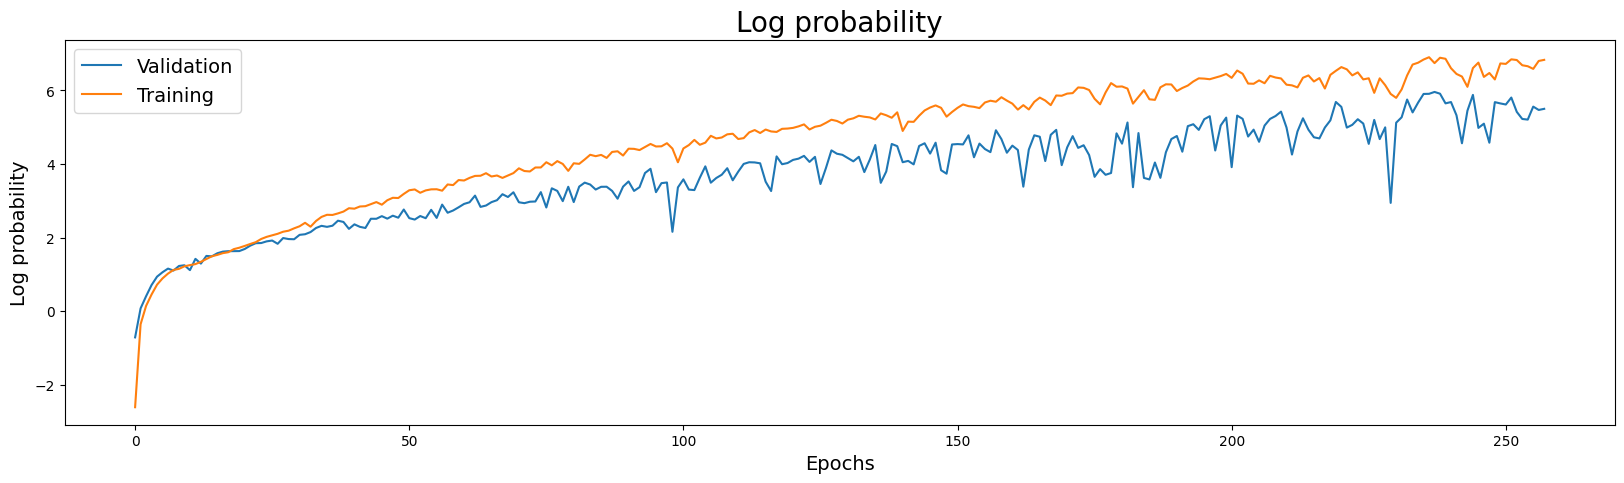

In [110]:
plt.figure(figsize=(20, 5))
plt.title("Log probability", fontsize=20)
plt.plot(best_infer.summary["validation_log_probs"], label="Validation")
plt.plot(best_infer.summary["training_log_probs"], label="Training")
plt.legend(fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Log probability", fontsize=14);

In [111]:
## Save a posterior
# with open("./data/posterior_7_1.pkl", "wb") as f:
#     pickle.dump(posterior, f)

In [112]:
## Load a posterior
# with open("./data/posterior_7.pkl", "rb") as f:
#     posterior = pickle.load(f)

In [134]:
# Get the observed trace
theta_true, theta_torch_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)
print("theta_true.shape: ", theta_true.shape)
print("x_trace_true.shape: ", x_trace_true.shape)

theta_true.shape:  (5, 1, 1)
x_trace_true.shape:  (1, 249999)


In [135]:
# Compute the summary statistics for the observed trace
summary_stats_true = compute_summary_statistics(x_trace_true[0], theta_true[:, 0])
s_true = select_summary_statistics(summary_stats_true, selected_stats, DeltaT, z_score=z_score, 
                                   cl_lin=cl_lin, cl_log=cl_log, fit_cxx=fit_corr, fit_s_redx=fit_s_redx)

/home/lapo/Desktop/LCPb-Project/Code/Notebooks/./../../InternalLibrary/StatisticalFunctions.py:427: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)
/home/lapo/Desktop/LCPb-Project/Code/Notebooks/./../../InternalLibrary/StatisticalFunctions.py:427: RuntimeWarning: overflow encountered in multiply
  return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)


In [136]:
# Sample from the posterior
samples = posterior.sample((int(1e5),), x=s_true)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

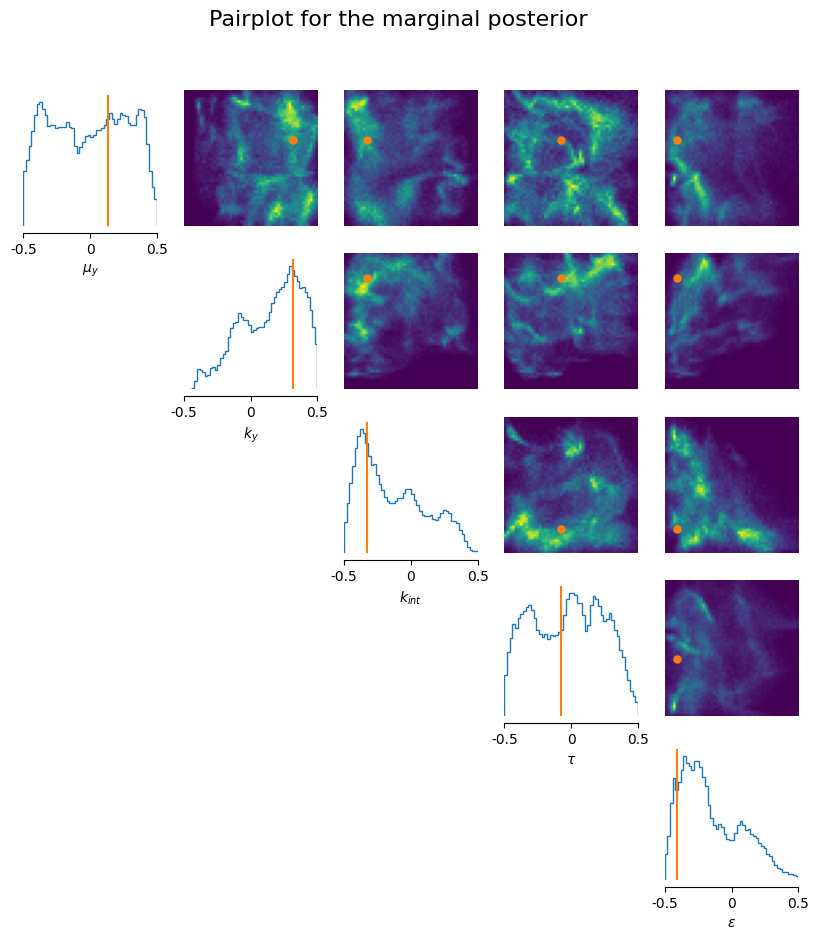

In [137]:
# Pairplot
label_theta = [r"$\mu_y$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$"]
prior_limits_list = get_prior_limit_list(prior_limits)

prior_limits_list = [[-0.5, 0.5] for _ in range(len(prior_limits_list))]


# Rescaling the parameters
_ = analysis.pairplot(samples, points=[rescale_theta(theta_torch_true.T, prior_limits)], 
                      limits=prior_limits_list, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

## ENTROPY PRODUCTION & PERFORMANCES

These are the formulas used to compute the entropy production
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$
$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

In [138]:
# Compute the mean and mode of the posterior for each parameter
def get_centroids_from_samples(samples, std=False):
    mean_params = np.array([])
    mode_params = np.array([])
    std_params = np.array([])

    for i in range(5):
        # Retrive the samples for the parameter i
        params = samples[:,i].numpy()
        # Compute the mean
        mean_params = np.concatenate((mean_params, [np.mean(params)]))
        # Compute the mode
        hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
        max_index = np.argmax(hist)
        mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
        mode_params = np.concatenate((mode_params, [mode]))
        # Compute the std
        if std: std_params = np.concatenate((std_params, [np.std(params)]))

    mean_params = mean_params.reshape(5, 1)
    mode_params = mode_params.reshape(5, 1)
    if std: std_params = std_params.reshape(5, 1)
    
    if std: return mean_params, mode_params, std_params
    return mean_params, mode_params

#get_centroids_from_samples(samples)

In [139]:
# Compare theoretical entropy with the one computed from the posterior
def CompareTheoreticalSigma(posterior, n_trials, n_samples, return_theta=False):
    n_trials = int(n_trials)
    n_samples = int(n_samples)

    # Make n_trials simulations
    theta_true, theta_torch_true = get_theta_from_prior(prior_limits, n_trials)
    x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)

    sigma_true = ComputeTheoreticalEntropy(theta_true)[0]
    sigma_posterior = np.zeros((n_trials, n_samples))

    # Infer the posterior
    for i in range(n_trials):
        print("Making the statistics: i = ", i+1, " / ", n_trials, end="\r")
        summary_stats_true = compute_summary_statistics(x_trace_true[i], theta_true[:, i])
        s_true = select_summary_statistics(summary_stats_true, selected_stats, DeltaT, 
                    z_score=z_score, cl_lin=cl_lin, cl_log=cl_log, fit_cxx=fit_corr, fit_s_redx=fit_s_redx)
        rescaled_samples = posterior.sample((n_samples,), x=s_true, show_progress_bars=False)
        samples = rescale_theta_inv(rescaled_samples, prior_limits)

        sigma_samples = ComputeTheoreticalEntropy(samples.numpy().T)[0]
        sigma_posterior[i, :] = sigma_samples[:, 0]

    if return_theta == False: return sigma_true, sigma_posterior
    if return_theta == True: return sigma_true, sigma_posterior, theta_true

In [140]:
%%time
n_trials = 20
sigma_true, sigma_posterior, theta_true = CompareTheoreticalSigma(posterior, n_trials, 1e5, return_theta=True)

CPU times: user 6min 43s, sys: 3min 5s, total: 9min 48s
Wall time: 5min 6s


In [141]:
def get_credibility_interval(single_sigma_posterior, c_level):
    pdf = np.sort(single_sigma_posterior)
    cdf = np.arange(1, len(pdf) + 1) / len(pdf)
    alpha = (1-c_level)/2
    region = pdf[(cdf > alpha) & (cdf < 1-alpha)]
    return region[0], region[-1]

#get_credibility_interval(sigma_posterior[0], 0.95)

In [142]:
def get_mode(x):
    hist, bin_edges = np.histogram(x, bins=int(np.sqrt(len(x))))
    max_index = np.argmax(hist)
    mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
    return mode

In [143]:
mode_array = np.array([get_mode(sigma_posterior[i]) for i in range(len(sigma_true))])
mean_array = np.mean(sigma_posterior, axis=1)
print("Corr(true_value, mode) = ", np.corrcoef(mode_array, sigma_true.reshape(n_trials,))[0, 1])
print("Corr(true_value, mean) = ", np.corrcoef(mean_array, sigma_true.reshape(n_trials,))[0, 1])

Corr(true_value, mode) =  0.9691411819691772
Corr(true_value, mean) =  0.9744440631120526


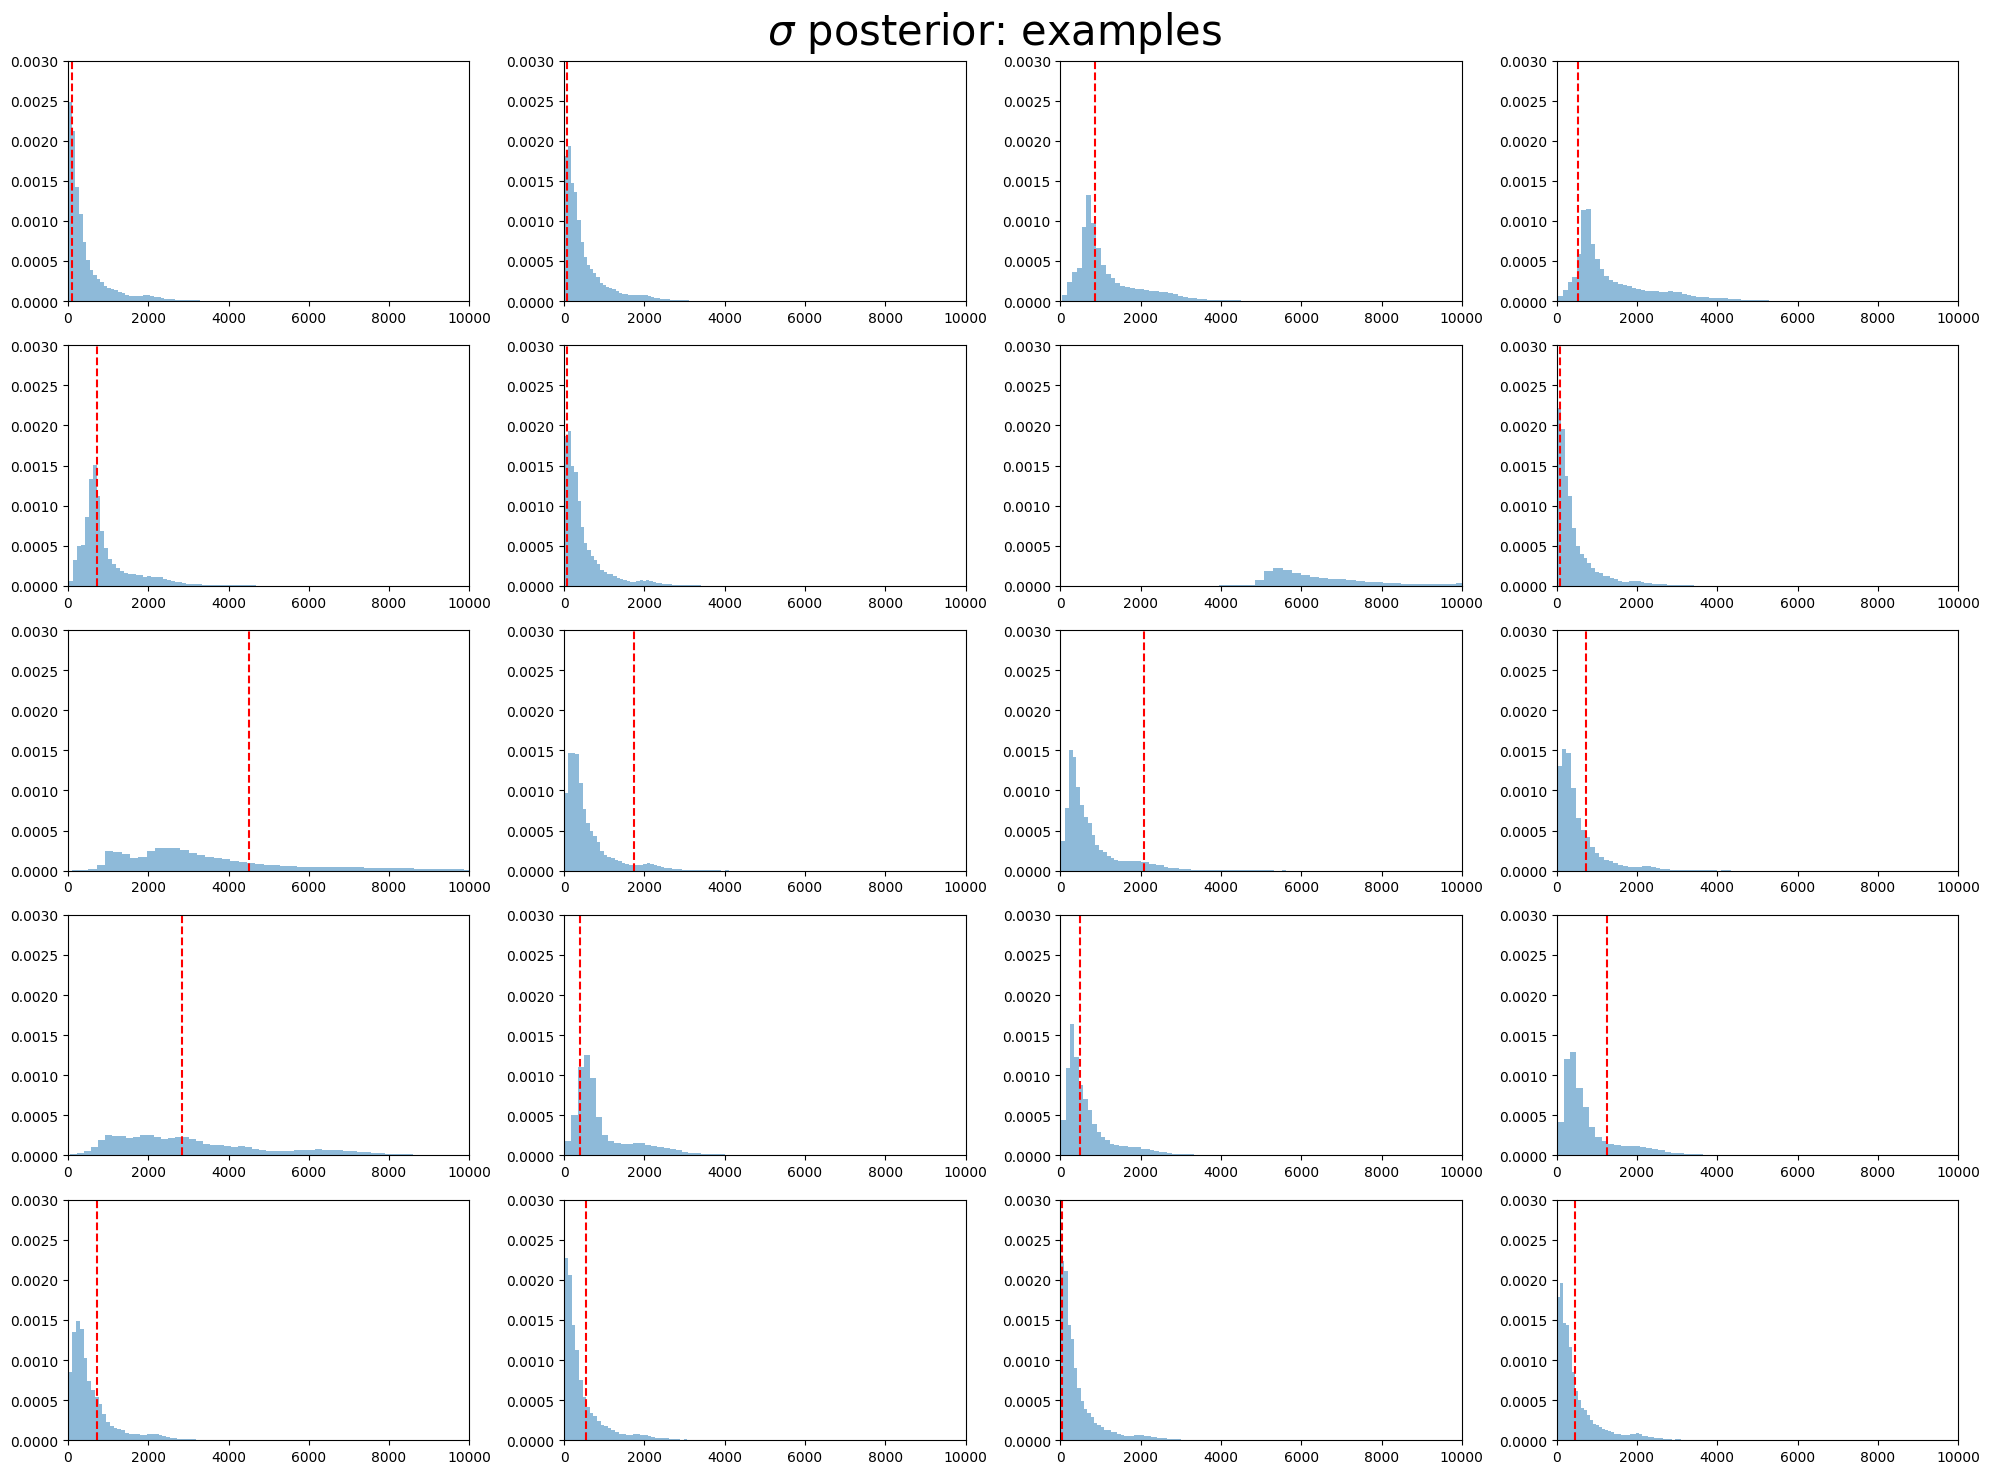

In [144]:
fig, ax = plt.subplots(5, 4, figsize=(20, 15))
fig.suptitle(r"$\sigma$ posterior: examples", fontsize=30)
for i in range(20):
    ax[i//4, i%4].hist(sigma_posterior[i], bins=100, density=True, alpha=0.5)
    ax[i//4, i%4].axvline(sigma_true[i], color='r', linestyle='--')
    #ax[i//4, i%4].axvline(get_mode(sigma_posterior[i]), color='g')
    ax[i//4, i%4].set_xlim(0, 10000)
    ax[i//4, i%4].set_ylim(0, 0.003)

fig.tight_layout()

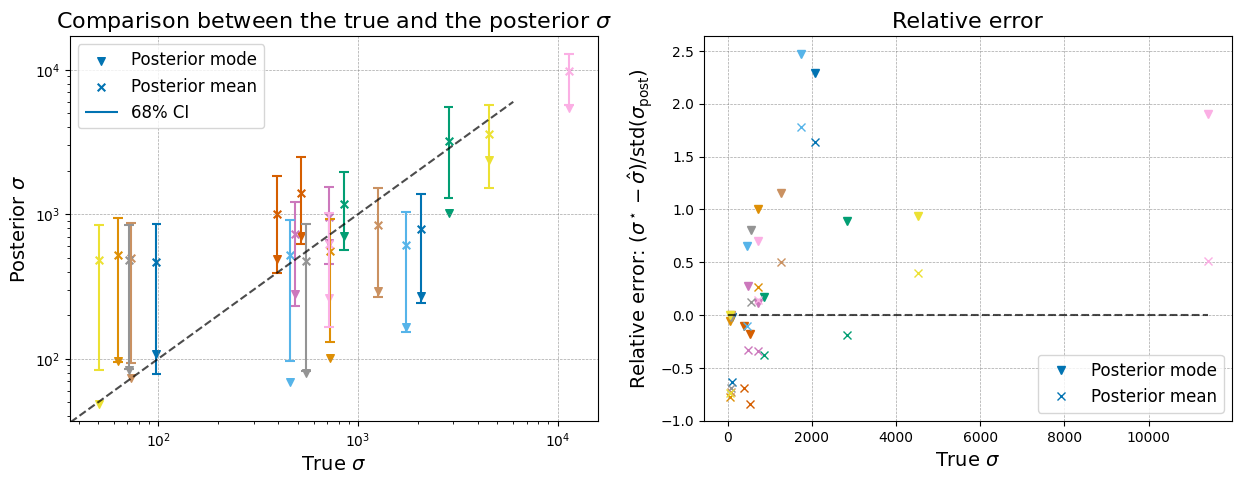

In [145]:
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", n_colors=len(sigma_true))

plt.subplot(121)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    cl = get_credibility_interval(sigma_posterior[i], 0.68)
    if i == 0:
        plt.scatter(sigma_true[i], mode, label=f"Posterior mode", s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, label=f"Posterior mean", s=30, marker="x", color=colors[i])
        plt.vlines(sigma_true[i], cl[0], cl[1], color=colors[i], label="68% CI")
    else:
        plt.scatter(sigma_true[i], mode, s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, s=30, marker="x", color=colors[i])
        plt.vlines(sigma_true[i], cl[0], cl[1], color=colors[i])
    
    cap_size = 0.05  # Adjust this value for the desired cap size
    cap_left = sigma_true[i] / (10 ** (cap_size / 2))
    cap_right = sigma_true[i] * (10 ** (cap_size / 2))
    plt.hlines(cl[0], cap_left, cap_right, color=colors[i])
    plt.hlines(cl[1], cap_left, cap_right, color=colors[i])

#plt.xlim([-100, 6e3])
plt.xscale("log")
#plt.ylim([-100, 6e3])
plt.yscale("log")
plt.plot([0, 6e3], [0, 6e3], color='black', linestyle='--', alpha=0.7)  
plt.xlabel(r"True $\sigma$", fontsize=14)
plt.ylabel(r"Posterior $\sigma$", fontsize=14)
plt.title(r"Comparison between the true and the posterior $\sigma$", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(122)
plt.title("Relative error", fontsize=16)
plt.xlabel("True $\sigma$", fontsize=14)
plt.ylabel(r"Relative error: $(\sigma^\star - \hat{\sigma})/\text{std}(\sigma_{\text{post}})$", fontsize=14)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    std = np.std(sigma_posterior[i])
    if i == 0:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/std, 'v', label=f"Posterior mode", color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/std, 'x', label=f"Posterior mean", color=colors[i])
    else:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/std, 'v', color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/std, 'x', color=colors[i])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.hlines(y=0, xmin=0, xmax=np.max(sigma_true), color='black', linestyle='--', alpha=0.7)
plt.legend(loc="lower right", fontsize=12);

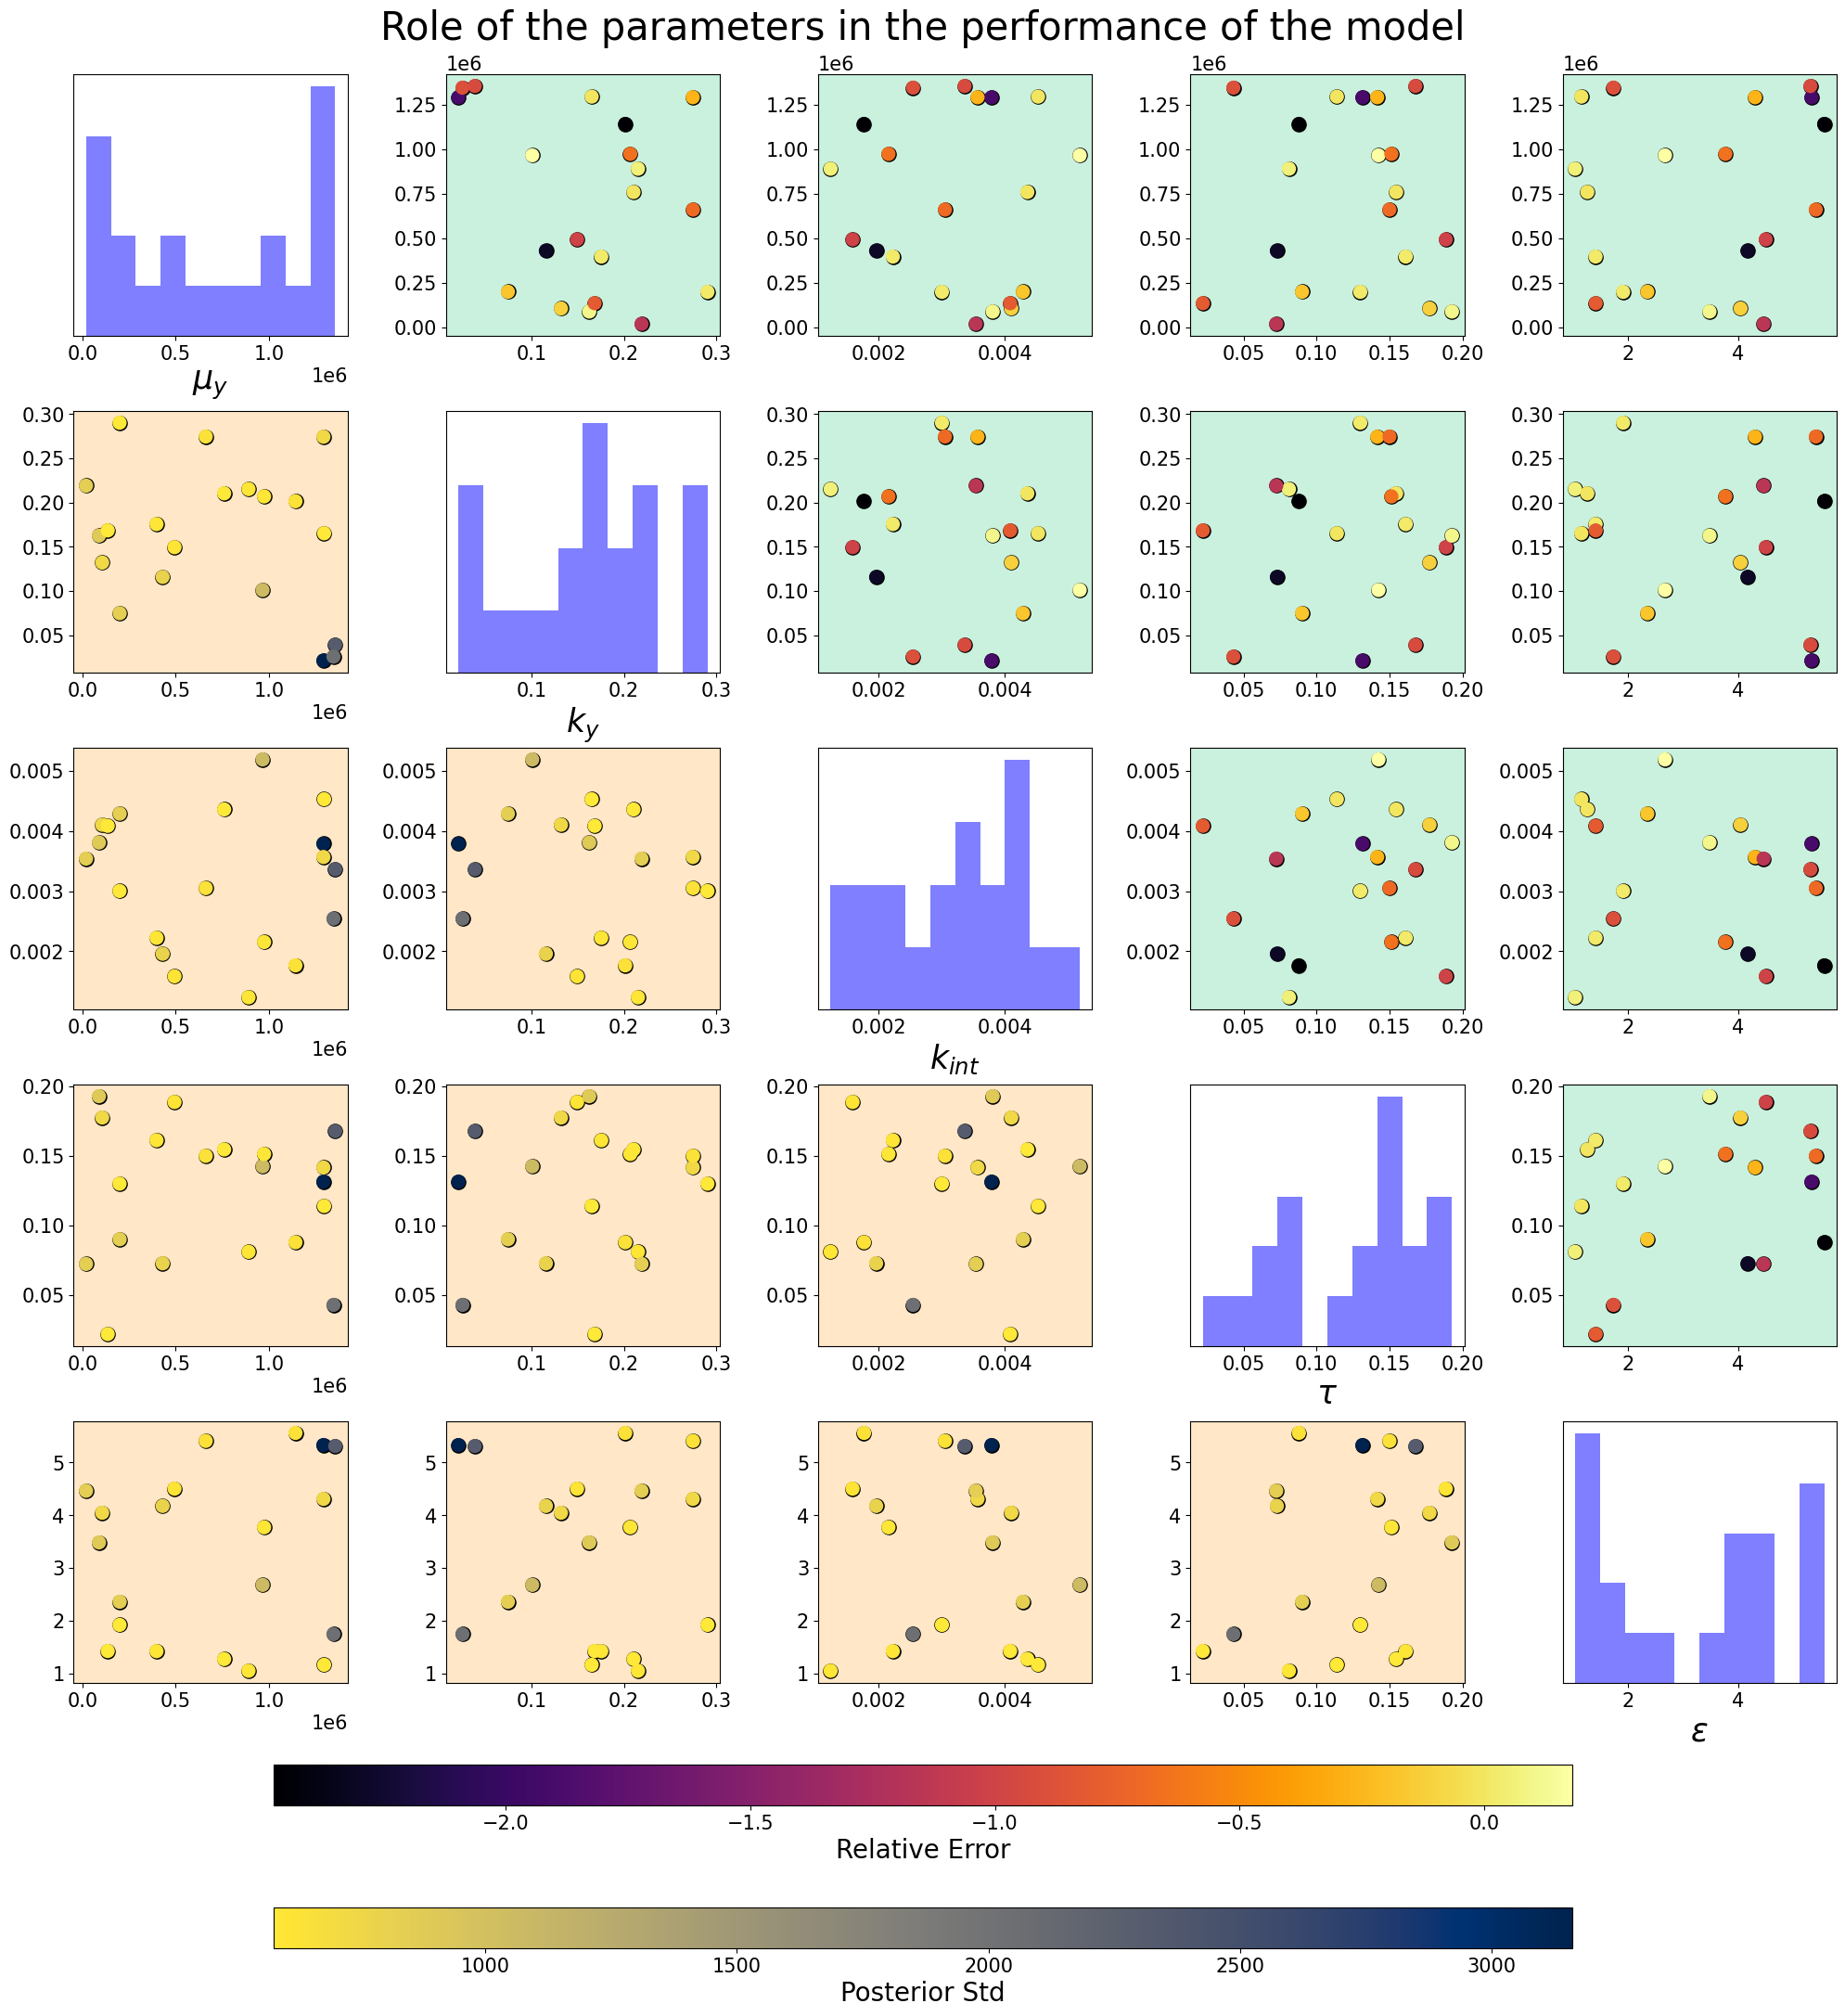

In [146]:
label_theta = [r"$\mu_y$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$"]
prior_limits_list = get_prior_limit_list(prior_limits)

fig, axs = plt.subplots(5, 5, figsize=(20, 22))
fig.suptitle("Role of the parameters in the performance of the model", fontsize=30)

# Diagonal: sample from the prior
for i in range(5):
    ax = axs[i, i]
    ax.hist(theta_true[i], bins=10, alpha=0.5, color='blue')
    ax.set_xlabel(label_theta[i], fontsize=25)
    ax.set_yticks([])
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.get_offset_text().set_fontsize(15)

# Upper triangular: scatter plot of the relative error
mode_array = np.array([get_mode(sigma_posterior[i]) for i in range(len(sigma_true))])
#err = (sigma_true - mode_array) / sigma_true
err = (mode_array - sigma_true.reshape(20,)) / np.std(sigma_posterior, axis=1)
for i in range(5):
    for j in range(i + 1, 5):
        ax = axs[i, j]
        ax.scatter(theta_true[j], theta_true[i], c='black', s=120, alpha=1)
        scatter_err = ax.scatter(theta_true[j], theta_true[i], c=err, cmap="inferno", s=100, alpha=1)
        ax.set_facecolor('#CAF1DE')
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.yaxis.get_offset_text().set_fontsize(15)

# Lower triangular: scatter plot of the posterior std
post_std = np.array([np.std(sigma_posterior[i]) for i in range(len(sigma_true))])
for i in range(5):
    for j in range(i):
        ax = axs[i, j]
        ax.scatter(theta_true[j], theta_true[i], c='black', s=120, alpha=1)
        scatter_std = ax.scatter(theta_true[j], theta_true[i], c=post_std, cmap="cividis_r", s=100, alpha=1)
        ax.set_facecolor('#FFE7C7')
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.xaxis.get_offset_text().set_fontsize(15)

fig.tight_layout(rect=[0, 0, 1, 0.99])

# Add colorbars
fig.subplots_adjust(bottom=0.16)  # Make space at the bottom for colorbars
cbar_ax_err = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # [left, bottom, width, height]
cbar_err = fig.colorbar(scatter_err, cax=cbar_ax_err, orientation='horizontal', label='Relative Error')
cbar_err.ax.tick_params(labelsize=15)  # Change the fontsize of the ticks
cbar_err.set_label('Relative Error', fontsize=20)  # Change the fontsize of the label
cbar_ax_std = fig.add_axes([0.15, 0.03, 0.7, 0.02])  # [left, bottom, width, height]
cbar_std = fig.colorbar(scatter_std, cax=cbar_ax_std, orientation='horizontal', label='Posterior Std Dev')
cbar_std.ax.tick_params(labelsize=15)  # Change the fontsize of the ticks
cbar_std.set_label('Posterior Std', fontsize=20)  # Change the fontsize of the label



## Marginalization of the single parameters

In this section, we try to evaluate $\sigma$ from the marginalized distributions of the parameters. We assume the error of each parameter to be the standard deviation of the marginal distribution and we neglect the correlations. 

In [43]:
def ErrorTheoreticalSigma(mean_params, err_params, mu_x = 2.8e4, k_x = 6e-3):
    mean_params = mean_params.reshape(5)
    err_params = err_params.reshape(5)
    mean_mu_y, mean_k_y, mean_k_int, mean_tau, mean_eps = mean_params
    err_mu_y, err_k_y, err_k_int, err_tau, err_eps = err_params

    mu_y, k_y, k_int, tau, eps = sym.symbols('mu_y k_y k_int tau eps')
    
    # Define the entropy
    sigma = (mu_y * eps**2) / ((1 + k_y * mu_y * tau) - ((k_int ** 2 * mu_x * mu_y * tau ** 2) / (1 + k_x * mu_x * tau)))

    # Compute the derivatives
    d_mu_y = sym.diff(sigma, mu_y)
    d_k_y = sym.diff(sigma, k_y)
    d_k_int = sym.diff(sigma, k_int)
    d_tau = sym.diff(sigma, tau)
    d_eps = sym.diff(sigma, eps)

    # Error propagation (independent variables)
    err_sigma = sym.sqrt((d_mu_y * err_mu_y)**2 + (d_k_y * err_k_y)**2 + (d_k_int * err_k_int)**2 + (d_tau * err_tau)**2 + (d_eps * err_eps)**2)
    err_sigma = err_sigma.subs({mu_y: mean_mu_y, k_y: mean_k_y, k_int: mean_k_int, tau: mean_tau, eps: mean_eps})
    return float(err_sigma)

In [44]:
n_trials = 10
sigma_true = np.zeros((n_trials, 1))
sigma_posterior_mean = np.zeros((n_trials, 1))
sigma_posterior_mode = np.zeros((n_trials, 1))
sigma_err = np.zeros((n_trials, 1))

for i in range(n_trials):
    print("Making the statistics: i = ", i+1, " / ", n_trials, end="\r")
    # Make the test simulation
    theta_true, theta_torch_true = get_theta_from_prior(prior_limits, 1)
    x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)

    # Compute the summary statistics for the observed trace and make the inference
    summary_stats_true = compute_summary_statistics(x_trace_true[0], theta_true[:, 0])
    s_true = select_summary_statistics(summary_stats_true, selected_stats, DeltaT, z_score=z_score, 
                  cl_lin=cl_lin, cl_log=cl_log, fit_cxx=fit_corr, fit_s_redx=fit_s_redx) 
    samples = posterior.sample((int(1e5),), x=s_true, show_progress_bars=False)
    
    # Compute the mean and mode of the marginal posterior for each parameter
    mean_i, mode_i, std_i = get_centroids_from_samples(samples, std=True)
    mean_i = rescale_theta_inv(torch.Tensor(mean_i.reshape((1, 5))), prior_limits).numpy().reshape((5,1,1))
    mode_i = rescale_theta_inv(torch.Tensor(mode_i.reshape((1, 5))), prior_limits).numpy().reshape((5,1,1))

    # Compute sigma directly from the centroids of the marginal posteriors
    sigma_true[i] = ComputeTheoreticalEntropy(theta_true)[0]
    sigma_posterior_mean[i] = ComputeTheoreticalEntropy(mean_i)[0]
    sigma_posterior_mode[i] = ComputeTheoreticalEntropy(mode_i)[0]
    sigma_err[i] = ErrorTheoreticalSigma(mean_i, std_i)

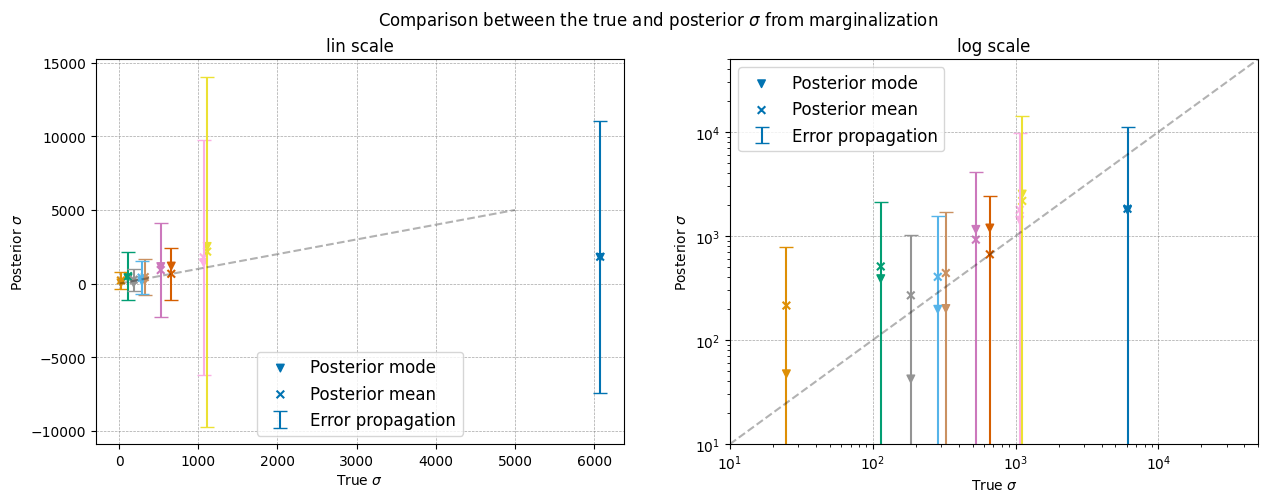

In [45]:
plt.figure(figsize=(15, 5))
plt.suptitle(r"Comparison between the true and posterior $\sigma$ from marginalization")

colors = sns.color_palette("colorblind", n_colors=len(sigma_true))

plt.subplot(121)
plt.title("lin scale")
plt.scatter(sigma_true, sigma_posterior_mode, marker="v", s=30,  label=f"Posterior mode", color=colors)
plt.scatter(sigma_true, sigma_posterior_mean, marker='x', s=30, label=f"Posterior mean", color=colors)
for i in range(n_trials):
    if i == 0: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i], label="Error propagation")
    else: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i])

plt.plot([10, 5e3], [10, 5e3], color='black', linestyle='--', alpha=0.3)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.xlabel(r"True $\sigma$")
plt.ylabel(r"Posterior $\sigma$")
plt.legend(fontsize=12)


plt.subplot(122)
plt.title("log scale")
plt.scatter(sigma_true, sigma_posterior_mode, marker="v", s=30,  label=f"Posterior mode", color=colors)
plt.scatter(sigma_true, sigma_posterior_mean, marker='x', s=30, label=f"Posterior mean", color=colors)
for i in range(n_trials):
    if i == 0: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i], label="Error propagation")
    else: plt.errorbar(sigma_true[i], sigma_posterior_mean[i], yerr=sigma_err[i], fmt=' ', capsize = 5, ecolor=colors[i])

plt.plot([10, 5e4], [10, 5e4], color='black', linestyle='--', alpha=0.3)

plt.xlim((10, 5e4))
plt.ylim((10, 5e4))
plt.xscale("log")
plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.xlabel(r"True $\sigma$")
plt.ylabel(r"Posterior $\sigma$")
plt.legend(loc="upper left", fontsize=12);

In [47]:
# Print correlation between the true and the posterior sigma
print("Correlation between the true and the posterior sigma:")
print("Mode: ", np.corrcoef(sigma_true.reshape(n_trials,), sigma_posterior_mode.reshape(n_trials,))[0, 1])
print("Mean: ", np.corrcoef(sigma_true.reshape(n_trials,), sigma_posterior_mean.reshape(n_trials,))[0, 1])

Correlation between the true and the posterior sigma:
Mode:  0.5336515645025061
Mean:  0.6034702571066932


## Role of subsampling: lin vs log

(-5.0, -2.0)

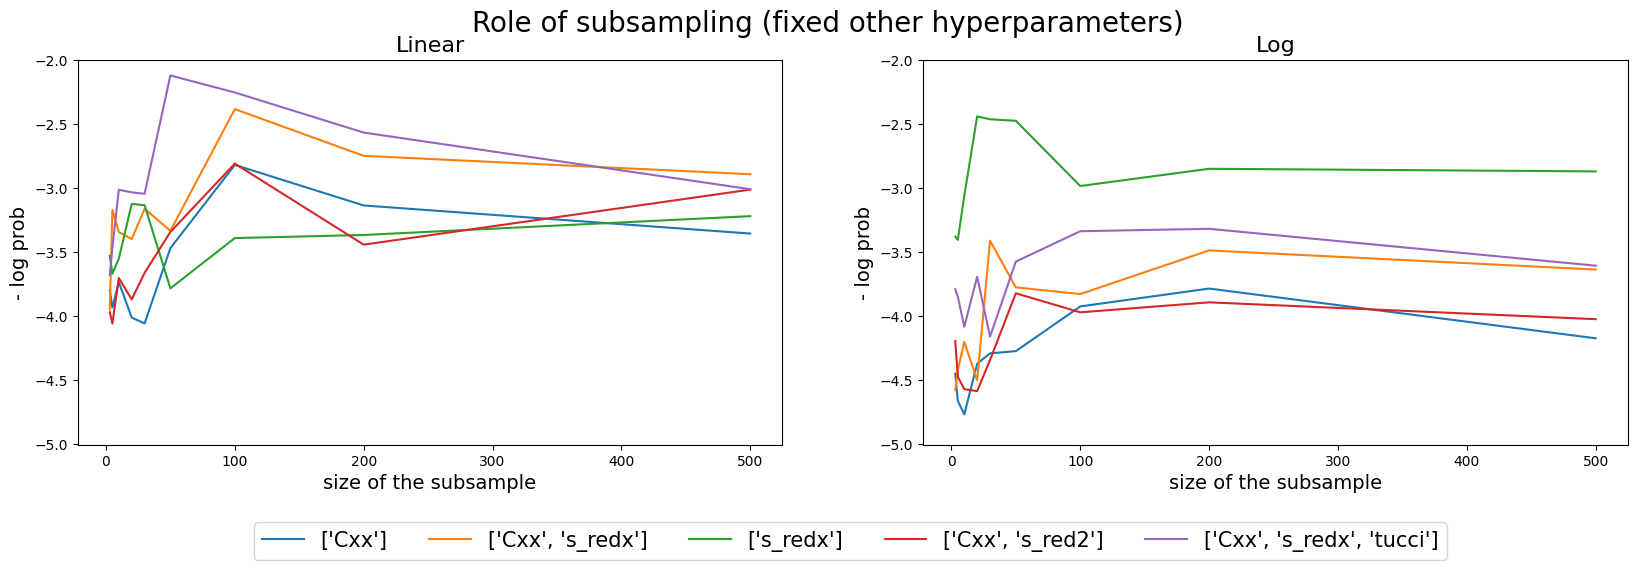

In [36]:
plt.figure(figsize=(20, 5))
plt.suptitle("Role of subsampling (fixed other hyperparameters)", fontsize=20)

with open("./data/cl_lin_results.pkl", "rb") as f: cl_lin_results = pickle.load(f)
with open("./data/cl_log_results.pkl", "rb") as f: cl_log_results = pickle.load(f)
stats = [["Cxx"], ["Cxx", "s_redx"], ["s_redx"], ["Cxx", "s_red2"], ["Cxx", "s_redx", "tucci"]]
cl_sizes = [3, 5, 10, 20, 30, 50, 100, 200, 500]

plt.subplot(121)
plt.title("Linear", fontsize=16)
for i in range(len(stats)):
    plt.plot(cl_sizes, cl_lin_results[i], label=stats[i])
plt.ylabel("- log prob", fontsize=14)
plt.xlabel("size of the subsample", fontsize=14)
plt.ylim((-5, -2))
plt.legend(ncols=len(stats), loc=(0.25, -0.3), fontsize=15)

plt.subplot(122)
plt.title("Log", fontsize=16)
for i in range(len(stats)):
    plt.plot(cl_sizes, cl_log_results[i])
plt.ylabel("- log prob", fontsize=14)
plt.xlabel("size of the subsample", fontsize=14)
plt.ylim((-5, -2))

## Comparison between analytical and empirical sigma

In [9]:
%%time
# Compute the obtained entropy production priors, individually for each simulation
emp_sigma_from_prior = np.array([])
sigma_from_prior = np.array([])

# n_sim = int(1e4)
# n_batch = int(1e2)

n_sim = int(1e2)
n_batch = int(1e1)

print("Computing %d simulations in %d batches" % (n_batch*(n_sim//n_batch), n_sim//n_batch))
for i in tqdm(range(n_sim//n_batch)):
    # Simulate the dynamics
    theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
    x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta)

    # Compute the empirical entropy production
    _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
    emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))

    # Compute the analytical entropy production
    sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
    sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))

    # Clear the memory (for safety)
    #del theta, theta_torch, prior_box, x_trace, f_trace, y_trace
    #del emp_sigma_vec, sigma_vec

Computing 100 simulations in 10 batches


100%|██████████| 10/10 [04:25<00:00, 26.52s/it]

CPU times: total: 4min 24s
Wall time: 4min 25s


In [15]:
print(np.corrcoef(emp_sigma_from_prior, sigma_from_prior)[0, 1])

0.9866104002572247


# CORRELLARTION WITH NUMBER OF POINTS

In [8]:
%%time
# compute the empirical and the analytical entropy for different lenghts of the trajectories (different TotalT)
n_sim = int(1e2)
n_batch = int(1e1)
TotalT = 13
correllation = []

# Simulate the dynamics
for j in np.arange(0,TotalT, 0.5):
    emp_sigma_from_prior = np.array([])
    sigma_from_prior = np.array([])
    for i in tqdm(range(n_sim//n_batch)):
        theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
        x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, j, theta)
        # compute the empirical entropy production
        _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
        emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))
        # compute the analytical entropy production
        sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
        sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))
    # compute the correllation
    corr = np.corrcoef(emp_sigma_from_prior, sigma_from_prior)[0, 1]
    correllation.append(corr)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]
c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 10/10 [08:19<00:00, 49.91s/it]

CPU times: total: 1h 40min 14s
Wall time: 1h 40min 26s


In [10]:
correllation

[nan,
 0.9712685825785967,
 0.8946251624720004,
 0.9289160286337464,
 0.8805794790214353,
 0.8306586193346873,
 0.9399948155765223,
 0.9499152527148363,
 0.9333984436501372,
 0.9519765036673415,
 0.8559025372395663,
 0.9822939517856737,
 0.8891514127748501,
 0.9556527716689608,
 0.9273863102296898,
 0.8949157387779519,
 0.98326342112586,
 0.8079112171532199,
 0.9610939400482635,
 0.9518424704312403,
 0.9388025895835859,
 0.9104193161244984,
 0.9456092542658868,
 0.9712039402438339,
 0.8814124953490737,
 0.9875101668258371]

Text(0.5, 1.0, 'Correlation between empirical and analytical entropy production')

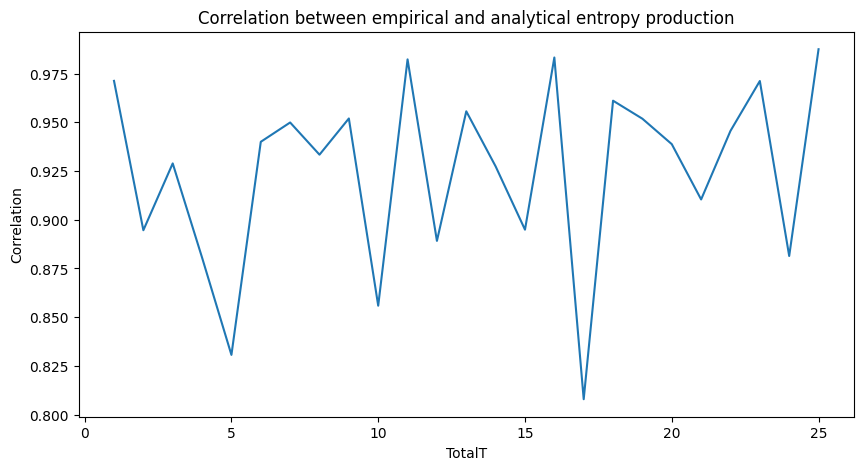

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(correllation)
ax.set_xlabel("TotalT")
ax.set_ylabel("Correlation")
ax.set_title("Correlation between empirical and analytical entropy production")

In [14]:
%%time
# compute the empirical and the analytical entropy for different lenghts of the trajectories (different TotalT)
n_sim = int(1e2)
n_batch = int(1e1)
TotalT = 0.2
correllation = []

# Simulate the dynamics
for j in np.arange(0.01,TotalT, 0.01):
    emp_sigma_from_prior = np.array([])
    sigma_from_prior = np.array([])
    for i in tqdm(range(n_sim//n_batch)):
        theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
        x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, j, theta)
        # compute the empirical entropy production
        _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
        emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))
        # compute the analytical entropy production
        sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
        sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))
    # compute the correllation
    corr = np.corrcoef(emp_sigma_from_prior, sigma_from_prior)[0, 1]
    correllation.append(corr)

100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

CPU times: total: 29.8 s
Wall time: 29.9 s


In [15]:
correllation

[0.05057318514772302,
 0.24365864754973257,
 0.15433792633903443,
 0.21439871456456064,
 0.9459587742699838,
 0.9176168816933389,
 0.16049174157142074,
 0.024699366215802255,
 0.20619768675142994,
 0.17341053774373777,
 0.8989573360655803,
 0.7801733525174777,
 0.8888328135521815,
 0.9068890974925385,
 0.9098194565945548,
 0.7580067370825687,
 0.9535361003673073,
 0.9769630717698816,
 0.8730714323951083]

Text(0.5, 1.0, 'Correlation between empirical and analytical entropy production')

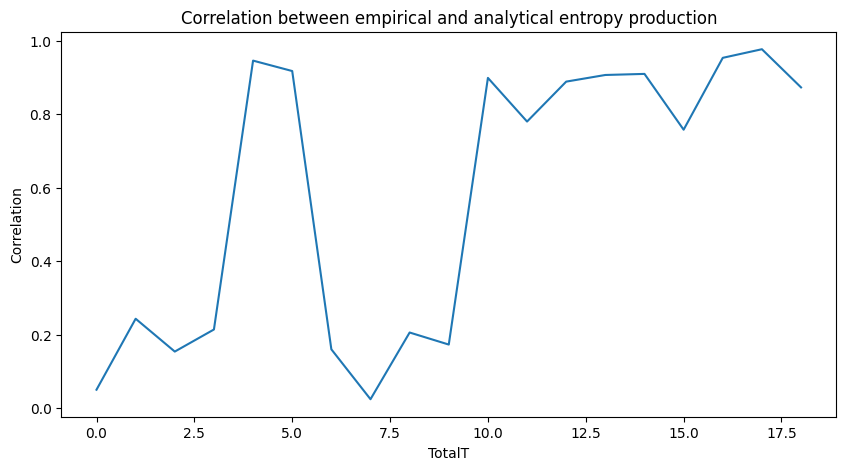

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(correllation)
ax.set_xlabel("TotalT")
ax.set_ylabel("Correlation")
ax.set_title("Correlation between empirical and analytical entropy production")

In [58]:
import os

if not os.path.exists('data'):
    os.makedirs('data')
    
action = "save"

if action == "save":
    with open("data/sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(sigma_from_prior, f)

    with open("data/emp_sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(emp_sigma_from_prior, f)

    with open("data/theta.pkl", 'wb') as f:
        pickle.dump(theta, f)

if action == "load":
    with open("data/sigma_from_prior.pkl", 'rb') as f:
        sigma_from_prior = pickle.load(f)

    with open("data/emp_sigma_from_prior.pkl", 'rb') as f:
        emp_sigma_from_prior = pickle.load(f)

    with open("data/theta.pkl", 'rb') as f:
        theta = pickle.load(f)

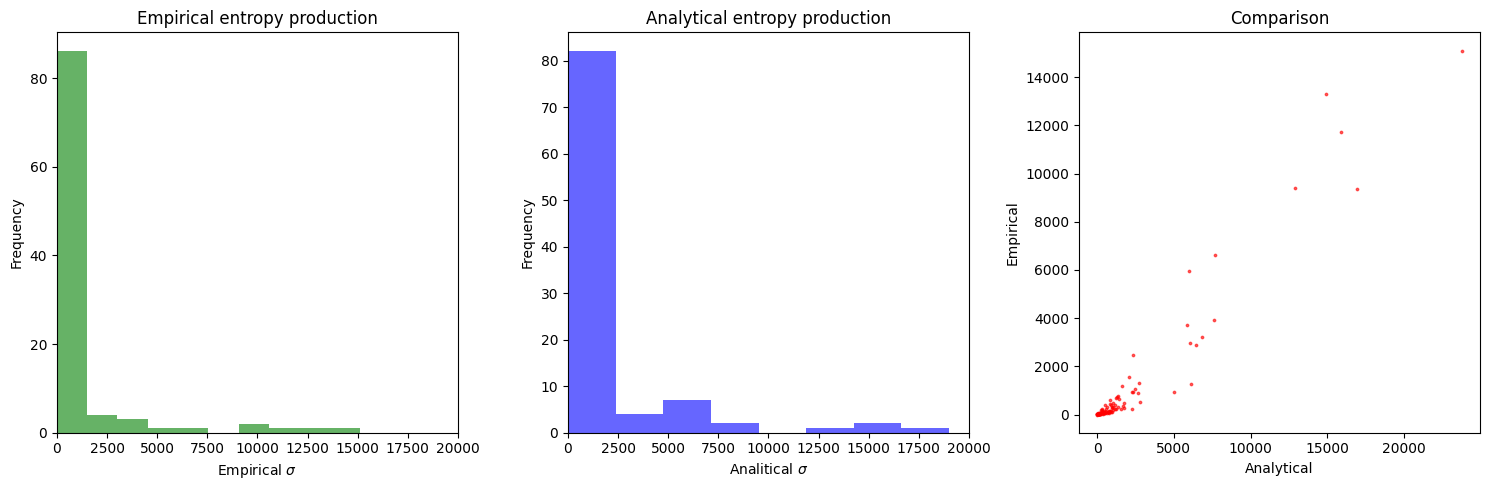

In [22]:
# do a figure with 3 subplots, 1 hist for empirical, 1 for analytical, 1 for the difference
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(emp_sigma_from_prior, bins=int(np.sqrt(len(sigma_from_prior))),alpha=0.6, color='g')
ax[0].set_xlim(0, 2e4)
ax[0].set_title("Empirical entropy production")
ax[0].set_xlabel(r"Empirical $\sigma$")
ax[0].set_ylabel("Frequency")
ax[1].hist(sigma_from_prior, bins=int(np.sqrt(len(sigma_from_prior))),alpha=0.6, color='b')

ax[1].set_title("Analytical entropy production")
ax[1].set_xlabel(r"Analitical $\sigma$")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(0,2e4)
ax[2].scatter(sigma_from_prior, emp_sigma_from_prior, alpha=0.6, color='r', s=3)
ax[2].set_title("Comparison")
ax[2].set_xlabel("Analytical")
ax[2].set_ylabel("Empirical")
plt.tight_layout()



In [12]:
corr = np.corrcoef(sigma_from_prior, emp_sigma_from_prior)
print("Correlation between the empirical and the analytical entropy production: ", corr[0, 1])

Correlation between the empirical and the analytical entropy production:  0.9658072013675296


In [13]:
scale_sigma = sigma_from_prior / emp_sigma_from_prior

In [23]:
np.mean(scale_sigma)

4.3229751096887785

------
## Vertical Slice Variance Check

In [32]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 6 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
transient = 3
t_corr = TotalT/50

# n_sim = int(10)

time_steps_amount = np.int64((TotalT-transient)/dt) # Number of steps
sampled_point_amount = np.int64((TotalT-transient)/DeltaT) # Number of sampled points
sampling_delta_time_steps = np.int64(DeltaT/dt) # Number of steps between samples
t = np.linspace(0., TotalT - transient, sampled_point_amount) # Time array
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}
tnice = [DeltaT for t in range(sampled_point_amount - 1)]
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
theta = np.repeat(theta, 100, axis=1)
x_trace, _, _ = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient);

Standard deviation of the standard deviaton of the traces 1.8221420049667358


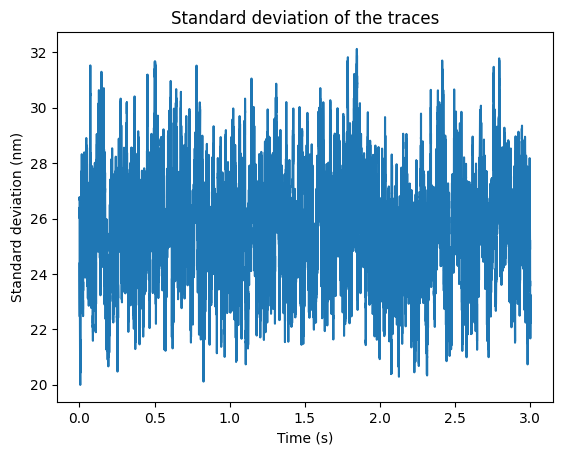

In [34]:
plt.plot(t,np.std(x_trace, axis=0));
plt.xlabel("Time (s)")
plt.ylabel("Standard deviation (nm)")
plt.title("Standard deviation of the traces")
print(f"Standard deviation of the standard deviaton of the traces {np.std(np.std(x_trace, axis=0))}")